In [113]:
tr_path = 'otatrain.csv'  # path to training data

!gdown --id '1c9OkEgKqH0Fx57j37s03uoi4Q_CVYvir' --output otatrain.csv

Downloading...
From: https://drive.google.com/uc?id=1c9OkEgKqH0Fx57j37s03uoi4Q_CVYvir
To: /content/otatrain.csv
2.68MB [00:00, 42.4MB/s]


# **Import Some Packages**

In [114]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# **Some Utilities**

You do not need to modify this part.

In [115]:
def random_seed_setup(seed):
    # For reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        return 'cuda'
    else:
        return 'cpu'
'''
def plot_learning_curve(loss_record, title=''):
    #Plot learning curve of your DNN (train & dev loss) 
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()
'''

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 50.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

In [116]:
class PatchOTA(Dataset):
    def __init__(self,
                 input_array,
                 mode='train',
                 normalize='none',
                 target_only=False,
                 norm_mean=None,
                 norm_std=None):
        self.mode = mode

      
        data = np.array(input_array[0:])[:, 0:].astype(float)
        
        if not target_only:
            feats = list(range(2))
        else:
            pass

        if mode == 'test':
            # Testing data
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            target = data[:, 2:]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 50 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 50 == 0]
            else:
                indices = list(range(len(data)))
                # only when mode == 'train_all' (i.e., using all data for training)
            
            data = data[indices]
            target = target[indices]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data)
            self.target = torch.FloatTensor(target)
        
        self.norm_mean = None
        self.norm_std = None

        if normalize == 'self':
            self.norm_mean = self.data.mean(dim=0).unsqueeze(0)
            self.norm_std = self.data.std(dim=0).unsqueeze(0)
            self.data = (self.data - self.norm_mean) / self.norm_std

        if normalize == 'given' and (norm_mean is not None) and (norm_std is not None):
            self.data = (self.data - norm_mean) / norm_std

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of the Covid19 Dataset ({} samples found, each dim = {})'
              .format(mode, self.data.shape[0], self.data.shape[1]))

    def __getitem__(self, index):
        if self.mode in ['train', 'dev', 'train_all']:
            return self.data[index], self.target[index]
        else:
            return self.data[index]

    def __len__(self):
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [117]:
def prep_dataloader(tr_path, tt_path, batch_size, n_jobs=0, target_only=False):
    tr_dataset = PatchOTA(
        tr_path, mode='train_all',
        normalize='self', 
        target_only=target_only)

    dv_dataset = PatchOTA(
        tr_path, mode='dev',
        normalize='given', 
        target_only=target_only,
        norm_mean=tr_dataset.norm_mean,
        norm_std=tr_dataset.norm_std)

    tt_dataset = PatchOTA(
        tt_path, mode='test',
        normalize='given',
        target_only=target_only,
        norm_mean=tr_dataset.norm_mean,
        norm_std=tr_dataset.norm_std)
    
    tr_dataloader = DataLoader(
        tr_dataset, batch_size,
        shuffle=True, drop_last=False,
        num_workers=n_jobs, pin_memory=True)
    
    dv_dataloader = DataLoader(
        dv_dataset, batch_size,
        shuffle=False, drop_last=False,
        num_workers=n_jobs, pin_memory=True)

    tt_dataloader = DataLoader(
        tt_dataset, batch_size,
        shuffle=False, drop_last=False,
        num_workers=n_jobs, pin_memory=True)
    
    return tr_dataloader, dv_dataloader, tt_dataloader

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [118]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim, l2_reg=0.):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        self.net = nn.Sequential(
            nn.Linear(input_dim, 91),
            nn.RReLU(),  # randomized ReLU
            nn.Linear(91, 25)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        self.l2_reg = l2_reg

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target, is_train=True):
        ''' Calculate loss '''
        total_loss = 0

        mse_loss = self.criterion(pred, target)
        total_loss += mse_loss
        if is_train and self.l2_reg > 0.:
            reg_loss = 0
            for param in self.parameters():
                reg_loss += torch.norm(param, p=2)
            total_loss += reg_loss * self.l2_reg
        
        return total_loss, mse_loss

# **Train/Dev/Test**

## **Training**

In [119]:
def train(tr_set, dv_set, model, config, device):
    n_epochs = config['n_epochs']
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    loss_record = {'train': [], 'dev': []}
    min_mse = 1000.
    epoch = 0
    while epoch < n_epochs:
        model.train()
        for i, (x, y) in enumerate(tr_set):
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total_loss, mse_loss = model.cal_loss(pred, y, is_train=True)
            total_loss.backward()
            optimizer.step()
            loss_record['train'].append(total_loss.detach().cpu().item())

        dev_mse = dev(dv_set, model, device)

        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1
        
        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))

    return min_mse, loss_record

def dev(dv_set, model, device):
    model.eval()
    total_loss = 0
    for x, y in dv_set:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            _, mse_loss = model.cal_loss(pred, y, is_train=False)
        total_loss += mse_loss.detach().cpu().item() * len(x)
    total_loss = total_loss / len(dv_set.dataset)
   # print('total_loss =', total_loss)
    return total_loss

## **Testing**

In [120]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds[0]

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [121]:
device = random_seed_setup(42097)
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False

config = {
    'n_epochs': 10000,                  # maximum number of epochs
    'batch_size': 20,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,                # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

In [122]:
with open('otatrain.csv', 'r') as fp:
    data = list(csv.reader(fp))
    horizontal_data = np.array(data[2:4516])[:, 2:]
    vertical_data = np.array(data[4518:9032])[:, 2:]
    total_data = np.array(data[9034:13548])[:, 2:]

In [123]:
horizontal_dataset = []
for j in range(301):
    for k in range(13):
        ls = []
        ls.append(4000+10*j)
        for element in horizontal_data[1+15*j+k][0:]:
            ls.append(float(element))
        horizontal_dataset.append(ls)

vertical_dataset = []
for j in range(301):
    for k in range(13):
        ls = []
        ls.append(4000+10*j)
        for element in vertical_data[1+15*j+k][0:]:
            ls.append(float(element))
        vertical_dataset.append(ls)

total_dataset = []
for j in range(301):
    for k in range(13):
        ls = []
        ls.append(4000+10*j)
        for element in total_data[1+15*j+k][0:]:
            ls.append(float(element))
        total_dataset.append(ls)

In [124]:
horizontal_test = []
horizontal_test.append([4007.5,8.5])
for ele in horizontal_dataset:
    horizontal_test.append(ele[0:2])

# **Load data and model**

In [125]:
tr_set, dv_set, tt_set = prep_dataloader(
    horizontal_dataset, horizontal_test, config['batch_size'], 
    target_only=target_only)

Finished reading the train_all set of the Covid19 Dataset (3913 samples found, each dim = 2)
Finished reading the dev set of the Covid19 Dataset (79 samples found, each dim = 2)
Finished reading the test set of the Covid19 Dataset (3914 samples found, each dim = 2)


In [126]:
model = NeuralNet(tr_set.dataset.dim, 0.001).to(device)  # Construct model and move to device

# **Start Training!**

In [127]:
model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 25.0758)
Saving model (epoch =    2, loss = 22.1844)
Saving model (epoch =    3, loss = 19.9729)
Saving model (epoch =    4, loss = 18.5105)
Saving model (epoch =    5, loss = 17.3763)
Saving model (epoch =    6, loss = 16.5914)
Saving model (epoch =    7, loss = 16.0129)
Saving model (epoch =    8, loss = 15.6954)
Saving model (epoch =    9, loss = 15.3743)
Saving model (epoch =   10, loss = 15.1943)
Saving model (epoch =   11, loss = 14.9672)
Saving model (epoch =   12, loss = 14.9137)
Saving model (epoch =   13, loss = 14.7164)
Saving model (epoch =   14, loss = 14.6752)
Saving model (epoch =   15, loss = 14.5488)
Saving model (epoch =   16, loss = 14.3814)
Saving model (epoch =   18, loss = 14.2920)
Saving model (epoch =   19, loss = 14.0760)
Saving model (epoch =   20, loss = 14.0168)
Saving model (epoch =   21, loss = 13.9360)
Saving model (epoch =   22, loss = 13.8103)
Saving model (epoch =   23, loss = 13.7075)
Saving model (epoch =   24, loss

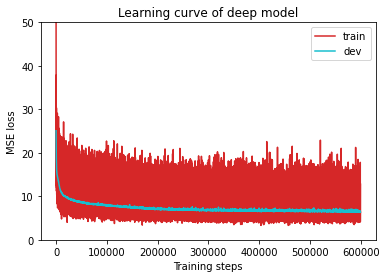

In [128]:
plot_learning_curve(model_loss_record[1], title='deep model')

In [129]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)

<All keys matched successfully>

In [130]:
 prediction = test(tt_set, model, device)

In [131]:
prediction

array([-16.482067, -15.82944 , -17.499752, -18.194996, -20.177834,
       -22.054968, -26.131437, -30.900627, -25.807747, -21.79853 ,
       -20.220394, -18.11305 , -16.888123, -17.784452, -17.1544  ,
       -18.564577, -21.1108  , -24.633991, -28.482769, -33.716404,
       -26.428297, -21.030073, -18.705435, -17.339794, -16.476482],
      dtype=float32)

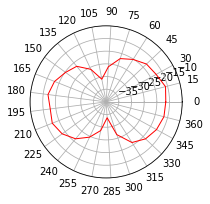

In [132]:
labels = np.array([str(15*j) for j in range(25)])
#資料個數
dataLenth = 25
#資料
data = np.array(prediction)

angles = np.linspace(0, 2*np.pi, dataLenth, endpoint=False)
data = np.concatenate((data, [data[0]])) # 閉合 # #將資料結合起來
angles = np.concatenate((angles, [angles[0]])) # 閉合

fig = plt.figure()
ax = fig.add_subplot(121, polar=True)# polar引數！！代表畫圓形！！！！
#111代表總行數總列數位置
ax.plot(angles, data, 'r', linewidth=1, markersize=0)# 畫線四個引數為x,y,標記和顏色，閒的寬度
ax.fill(angles, data, facecolor='r', alpha=0)# 填充顏色和透明度
ax.set_thetagrids(angles * 180/np.pi, labels, fontproperties="SimHei")
#ax.set_title("H dB",fontsize = 80, fontproperties="SimHei")
ax.set_rlim(-40,-10)
ax.grid(True)
plt.show()

In [133]:
vertical_test = []
vertical_test.append([4007.5,8.5])
for ele in vertical_dataset:
    vertical_test.append(ele[0:2])

In [134]:
tr_set, dv_set, tt_set = prep_dataloader(
    vertical_dataset, vertical_test, config['batch_size'], 
    target_only=target_only)

Finished reading the train_all set of the Covid19 Dataset (3913 samples found, each dim = 2)
Finished reading the dev set of the Covid19 Dataset (79 samples found, each dim = 2)
Finished reading the test set of the Covid19 Dataset (3914 samples found, each dim = 2)


In [135]:
model = NeuralNet(tr_set.dataset.dim, 0.001).to(device)  # Construct model and move to device

In [136]:
model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 31.3954)
Saving model (epoch =    2, loss = 28.7487)
Saving model (epoch =    3, loss = 27.2316)
Saving model (epoch =    4, loss = 26.4317)
Saving model (epoch =    5, loss = 25.4922)
Saving model (epoch =    6, loss = 24.6340)
Saving model (epoch =    7, loss = 23.7756)
Saving model (epoch =    8, loss = 22.9608)
Saving model (epoch =    9, loss = 22.2017)
Saving model (epoch =   10, loss = 21.6798)
Saving model (epoch =   11, loss = 21.6133)
Saving model (epoch =   12, loss = 20.9089)
Saving model (epoch =   13, loss = 20.8504)
Saving model (epoch =   14, loss = 20.5195)
Saving model (epoch =   15, loss = 20.2331)
Saving model (epoch =   17, loss = 19.9691)
Saving model (epoch =   18, loss = 19.8746)
Saving model (epoch =   20, loss = 19.4473)
Saving model (epoch =   21, loss = 19.3747)
Saving model (epoch =   22, loss = 19.1399)
Saving model (epoch =   23, loss = 18.9913)
Saving model (epoch =   25, loss = 18.8119)
Saving model (epoch =   26, loss

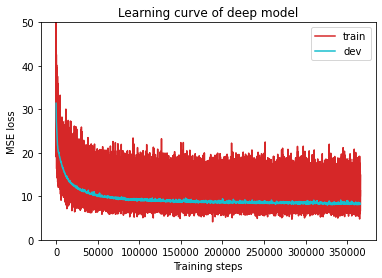

In [137]:
plot_learning_curve(model_loss_record[1], title='deep model')

In [138]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)

<All keys matched successfully>

In [139]:
prediction = test(tt_set, model, device)

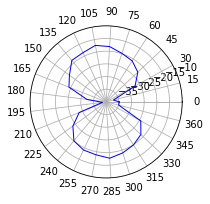

In [140]:
labels = np.array([str(15*j) for j in range(25)])
#資料個數
dataLenth = 25
#資料
data = np.array(prediction)

angles = np.linspace(0, 2*np.pi, dataLenth, endpoint=False)
data = np.concatenate((data, [data[0]])) # 閉合 # #將資料結合起來
angles = np.concatenate((angles, [angles[0]])) # 閉合

fig = plt.figure()
ax = fig.add_subplot(121, polar=True)# polar引數！！代表畫圓形！！！！
#111代表總行數總列數位置
ax.plot(angles, data, 'b', linewidth=1, markersize=0)# 畫線四個引數為x,y,標記和顏色，閒的寬度
ax.fill(angles, data, facecolor='r', alpha=0)# 填充顏色和透明度
ax.set_thetagrids(angles * 180/np.pi, labels, fontproperties="SimHei")
#ax.set_title("H dB",fontsize = 80, fontproperties="SimHei")
ax.set_rlim(-40,-10)
ax.grid(True)
plt.show()

In [141]:
total_test = []
total_test.append([4007.5,8.5])
for ele in total_dataset:
    total_test.append(ele[0:2])

In [142]:
tr_set, dv_set, tt_set = prep_dataloader(
    vertical_dataset, vertical_test, config['batch_size'], 
    target_only=target_only)

Finished reading the train_all set of the Covid19 Dataset (3913 samples found, each dim = 2)
Finished reading the dev set of the Covid19 Dataset (79 samples found, each dim = 2)
Finished reading the test set of the Covid19 Dataset (3914 samples found, each dim = 2)


In [143]:
model = NeuralNet(tr_set.dataset.dim, 0.001).to(device)  # Construct model and move to device

In [144]:
model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 31.8228)
Saving model (epoch =    2, loss = 28.6125)
Saving model (epoch =    3, loss = 27.0082)
Saving model (epoch =    4, loss = 25.8492)
Saving model (epoch =    5, loss = 24.9988)
Saving model (epoch =    6, loss = 24.3093)
Saving model (epoch =    7, loss = 23.6290)
Saving model (epoch =    8, loss = 22.9563)
Saving model (epoch =    9, loss = 22.5250)
Saving model (epoch =   10, loss = 22.0559)
Saving model (epoch =   11, loss = 21.5452)
Saving model (epoch =   12, loss = 21.2288)
Saving model (epoch =   13, loss = 20.9990)
Saving model (epoch =   14, loss = 20.9150)
Saving model (epoch =   15, loss = 20.5688)
Saving model (epoch =   16, loss = 20.3325)
Saving model (epoch =   17, loss = 20.2340)
Saving model (epoch =   18, loss = 20.0052)
Saving model (epoch =   19, loss = 19.8879)
Saving model (epoch =   20, loss = 19.6680)
Saving model (epoch =   21, loss = 19.6068)
Saving model (epoch =   22, loss = 19.5346)
Saving model (epoch =   23, loss

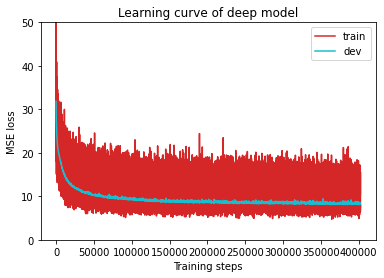

In [145]:
plot_learning_curve(model_loss_record[1], title='deep model')

In [146]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)

<All keys matched successfully>

In [147]:
prediction = test(tt_set, model, device)

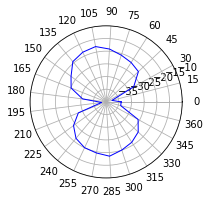

In [148]:
labels = np.array([str(15*j) for j in range(25)])
#資料個數
dataLenth = 25
#資料
data = np.array(prediction)

angles = np.linspace(0, 2*np.pi, dataLenth, endpoint=False)
data = np.concatenate((data, [data[0]])) # 閉合 # #將資料結合起來
angles = np.concatenate((angles, [angles[0]])) # 閉合

fig = plt.figure()
ax = fig.add_subplot(121, polar=True)# polar引數！！代表畫圓形！！！！
#111代表總行數總列數位置
ax.plot(angles, data, 'b', linewidth=1, markersize=0)# 畫線四個引數為x,y,標記和顏色，閒的寬度
ax.fill(angles, data, facecolor='g', alpha=0)# 填充顏色和透明度
ax.set_thetagrids(angles * 180/np.pi, labels, fontproperties="SimHei")
#ax.set_title("H dB",fontsize = 80, fontproperties="SimHei")
ax.set_rlim(-40,-10)
ax.grid(True)
plt.show()